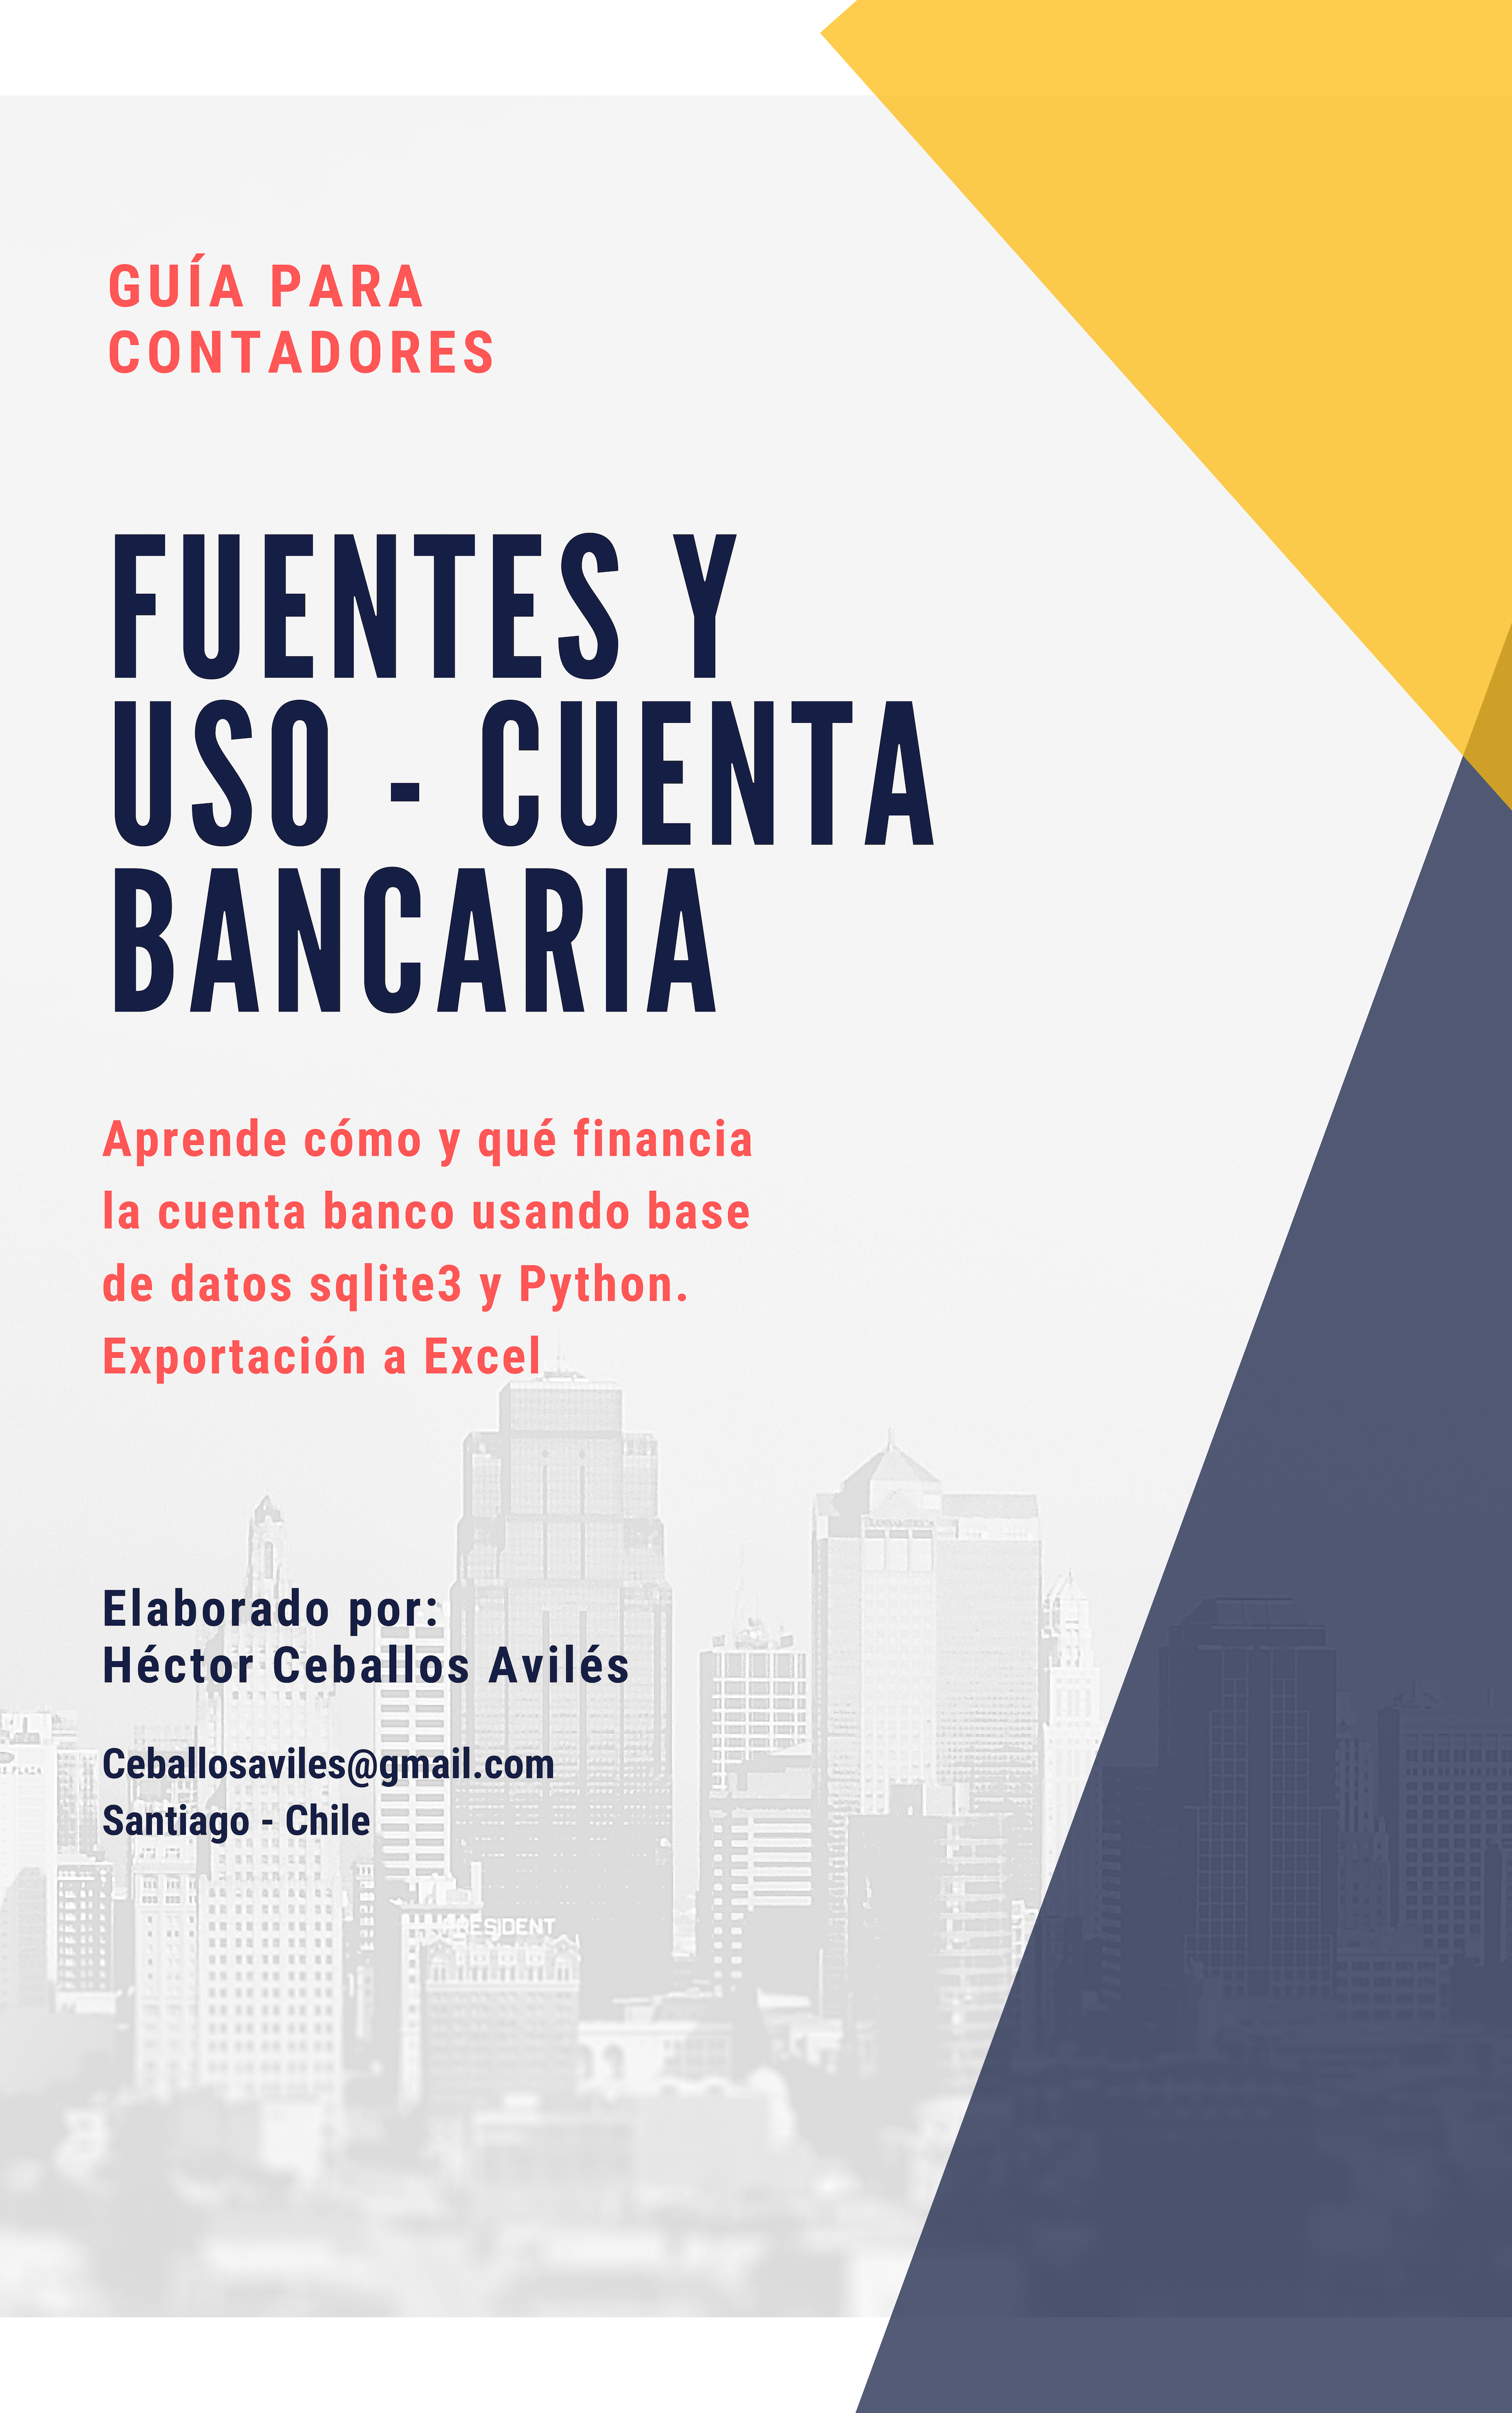

In [12]:
from IPython.display import Image
Image(filename='Fuentes_y_uso.png')

¡Hola! Soy Héctor.  

Soy Contador Auditor, y me encanta la música, el ajedrez, y más recientemente tengo una obsesión con el lenguaje de programación Python . Tanto es así que decidí iniciar un pequeño blog divertido para documentar mis aventuras explorando su utilidad en el mundo de la contabilidad.  


Si eres un contador que nunca ha oído hablar de Python o si has oído hablar de él pero no lo has usado, este es el blog para ti.  Te aliento a dejar comentarios y sugerencias sobre temas futuros para que podamos explorar Python juntos.  
Envíame cualquier idea que tengas a ceballosaviles@gmail.com.

Las publicaciones estarán en mi [Github](https://github.com/hceballos), en una de las siguientes categorías: 

#### •	Contador Auditor.
#### •	Control de Gestión.
#### •	Análisis de Datos.  

Siéntete libre de descargar y utilizar mi contenido.   


Saludos,
#### Héctor Ceballos 
## --------------------------------------------------------------------------------------------


  
Sin vueltas, vamos al grano.

### ¿QUÉ se quiere hacer?  
Teniendo como input la estructura del libro mayor con los registros contables de los últimos 5 años, se busca responder las siguientes preguntas:

¿Qué tipo de gastos está financiando el banco?<br>
¿Qué tipo de ingresos tiene ese banco?<br>
¿Cómo se han distribuido gastos e ingresos mes a mes durante este año?<br>
¿Cuál es el saldo mensual?<br>
¿Cuál es la sumatoria por cada ítem?


### ¿POR QUÉ se quiere hacer?
Permite ver el empleo de fondos que ha hecho la empresa (en este caso 1 banco) y la forma en que esas utilizaciones fueron financiadas.

### ¿CUÁNTO se quiere hacer?
METAS<br>
1) Reemplazar los procesos manuales que muchas personas usan para manipular datos en Excel y/o Access.<br>
2) Potenciar el rendimiento en el análisis de información.

### ¿CÓMO se va hacer?
En esta ocasión utilizaremos la biblioteca pandas, ya que proporciona su función “pivot_table”, similar a tablas dinámicas de Excel.  
Este artículo se centrará en explicar la función de panda pivot_table y cómo usarla para el análisis de datos.

### ¿A QUIÉNES va dirigido?
Esta guía está dirigida a todos aquellos contadores y profesionales en general que buscan ampliar sus conocimientos sobre el manejo de grandes volúmenes de información, generar información util y aumentar el rendimiento del trabajo diario.

### 1) Importación de librerias.

In [13]:
import sqlite3
import numpy as np
import pandas as pd

### 2) Conección con base de datos.

In [14]:
cnx = sqlite3.connect('data.db')

### 3) Construir consulta por según saldos de la semana actual.¶

In [15]:
consulta  = "\
SELECT \
    CUENTA, \
    FECHA, \
    TIPO, \
    NOMBRECCOSTO, \
    DEBE, \
    HABER \
FROM \
    MovimientosTabla LEFT JOIN Ccostos \
    ON MovimientosTabla.CENTRO_DE_COSTO = Ccostos.CCOSTO \
WHERE \
    cuenta like '1-01-02-002%'  \
    and fecha between date('NOW', 'START OF YEAR') and date('NOW') \
ORDER BY \
    TIPO DESC "

### 4) Lectura de consulta SQL en DataFrame.

In [16]:
datos = pd.read_sql_query(consulta, cnx)

### 5) Creamos columnas:
#### 1) 'SALDO' : toma la diferencia entre los movimientos de cargos y abonos.<br>2) Editamos columna 'NOMBRECCOSTO' : si en la columna 'NOMBRECCOSTO' no se encuentra datos, asignamos 'N/A' por defecto.

In [17]:
datos['SALDO'] = datos['DEBE'] - datos['HABER']
datos['NOMBRECCOSTO'] = ['N/A' if x is None else x for x in datos['NOMBRECCOSTO']]

### 6) Construir consulta cálculo años anteriores como saldo inicial del año actual.

In [18]:
consulta2 = " \
SELECT \
    CUENTA, \
    FECHA, \
    TIPO, \
    CENTRO_DE_COSTO as NOMBRECCOSTO, \
    sum (debe-haber) as SALDO \
FROM \
    MovimientosTabla \
WHERE \
    fecha between '2014-01-01' and '2017-12-31' \
    and cuenta like '1-01-02-002%' \
ORDER BY \
    TIPO DESC"

### 7) Lectura de consulta saldo inicial.

In [19]:
datos2 = pd.read_sql_query(consulta2, cnx)

### 8) Asignación de valores a las siguientes columnas:

In [20]:
datos2['FECHA'] = "2018-01-01"
datos2['TIPO'] = "Inicial"
datos2['NOMBRECCOSTO'] = "SALDO INICIAL"
datos2['DEBE'] = 0
datos2['HABER'] = 0

### 9) Anexo los datos del año actual con los datos de los años anteriores

In [21]:
frames = datos2.append(datos)

/Users/Hector/.pyenv/versions/3.6.6/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [22]:
df = pd.DataFrame(frames)

### 10) De la columna Fecha extraemos el mes

In [23]:
df['FECHA'] = pd.DatetimeIndex(df['FECHA']).month

### 11) Clasificamos, agrupamos y sumamos con la función 'pivot_table'

In [24]:
df = pd.pivot_table(df,
                    index = ["CUENTA", "TIPO", "NOMBRECCOSTO"],
                    values = ["SALDO"],
                    columns = ["FECHA"],
                    aggfunc = [np.sum],
                    fill_value = 0,
                    margins = True
                    )

columns = {'sum': 'CUENTAS RELACIONADAS AL RUT', 'SALDO': 'Saldo Mensual', 1: 'Ene', 2: 'Feb', 3: 'Mar',4: 'Abr', 5: 'May', 6: 'Jun',7: 'Jul', 8: 'Ago', 9: 'Sep', 10: 'Oct', 11: 'Nov',12: 'Dic', 'All': 'Acumulado'}
index = {'All': ' Total'}

x = df.rename(columns=columns, index=index)
x.style.format("{:,.0f}")

### 12) Exportar informacion a formato Excel.

In [25]:
writer = pd.ExcelWriter('coch_Banco_CON_Centro_de_Costos ELIMINAR.xlsx', engine='xlsxwriter')
x.to_excel(writer, sheet_name='Tabla Dinamica')
writer.save()